# **Entendimiento y Preparación de los Datos**
---


In [19]:
import gdown
import pandas as pd
import numpy as np
import os
import sys
import warnings
import zipfile
import re
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import keras
from skimage import util, transform
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **1. Carga de datos**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Ubicación de los datos
df_dir = '/content/drive/MyDrive/DL-Proyecto/Data/data_completa/'

In [22]:
## Cargar dataset
batch_size = 32
img_height = 180
img_width = 180

df = tf.keras.utils.image_dataset_from_directory(
    df_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1532 files belonging to 3 classes.


In [23]:
#importar funciones
import sys
sys.path.append('/content/drive/MyDrive/Proyecto_MDS6/src/nombre_paquete/preprocessing')


In [24]:
from conteo_functions import count_files
from formato_functions import get_file_formats

num_files = count_files(df_dir)
file_formats = get_file_formats(df_dir)

print(f"El total de imagenes en nuestro conjunto de datos es de: {num_files} (repartidos en tres segmentos o subcarpetas)")
print(f"Los formatos de archivo en la carpeta de imágenes son: {', '.join(file_formats)}")

El total de imagenes en nuestro conjunto de datos es de: 1532 (repartidos en tres segmentos o subcarpetas)
Los formatos de archivo en la carpeta de imágenes son: .jpg


Ahora calculemos el tamaño que ocupa el conjunto de datos en memoria:

In [25]:
from size_functions import get_size

total_size = get_size(df_dir) / (1024 ** 2)

print(f"El tamaño del conjunto de datos completo es de: {total_size:.2f} MB")

El tamaño del conjunto de datos completo es de: 1290.55 MB


### **1.2. Resumen de la Calidad de los datos**
---


Dado que nuestro conjunto de datos consta de 1532 imágenes, es crucial verificar su calidad inicial. Para ello, intentaremos abrir cada imagen y evaluar su integridad. Si una imagen resulta estar vacía o tiene todos sus píxeles con el mismo valor, la registraremos como un archivo problemático. Adicionalmente, este proceso nos permitirá identificar archivos corruptos o con formatos no reconocidos que no puedan abrirse correctamente.





In [26]:
from check_functions import check_image_files

image_errors = check_image_files(df_dir)

print(f"\n Problemas en los archivos de imagen: {len(image_errors)}")

if image_errors:
    for path, reason in image_errors:
        print(f"   - {reason} → {path}")

 Analizados 4 de 4 registros
 Problemas en los archivos de imagen: 0


### **1.3. Tipos de variables**
---


In [27]:
class_names = df.class_names
print("Clases:", class_names)

Clases: ['Healthy', 'Powdery', 'Rust']


Nuestro conjunto de datos se clasifica en tres etiquetas distintas: Healthy, Powdery y Rust. Ahora vamos a analizar la distribución de las imágenes dentro de cada una de estas clases y, además, verificar los tamaños de las imágenes para comprender mejor la composición y las características de nuestro dataset.


--- Conteo de Imágenes por Clase ---
Healthy    528
Rust       504
Powdery    500
Name: count, dtype: int64


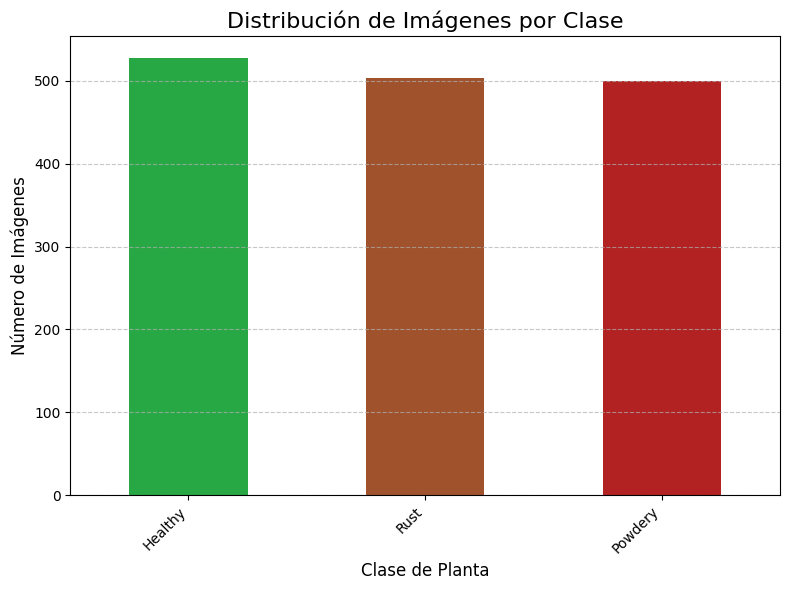

In [28]:
#Creamos los vectores para almacenar las dimensiones originales
all_image_paths = []
all_labels = []
image_sizes = []

for class_name in class_names:
    class_dir = os.path.join(df_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            all_image_paths.append(img_path)
            all_labels.append(class_name)
            image_sizes.append(img.size)

# Conteo de imágenes por clase
label_counts = pd.Series(all_labels).value_counts()
print("\n--- Conteo de Imágenes por Clase ---")
print(label_counts)

custom_colors = ['#28a745', '#A0522D', '#B22222']
plt.figure(figsize=(8, 6)) # Define el tamaño de la figura para el gráfico
label_counts.plot(kind='bar', color=custom_colors) # Crea el gráfico de barras
plt.title('Distribución de Imágenes por Clase', fontsize=16) # Título del gráfico
plt.xlabel('Clase de Planta', fontsize=12) # Etiqueta del eje X
plt.ylabel('Número de Imágenes', fontsize=12) # Etiqueta del eje Y
plt.xticks(rotation=45, ha='right') # Rota las etiquetas del eje X para mejor lectura
plt.grid(axis='y', linestyle='--', alpha=0.7) # Añade una cuadrícula suave en el eje Y
plt.tight_layout() # Ajusta el diseño para que todo quepa bien
plt.show() # Muestra el gráfico

Aunque nuestro conjunto de datos no presenta problemas de desbalanceo entre las clases, el número limitado de 1532 imágenes es una consideración importante. Para mejorar significativamente el rendimiento de nuestro modelo durante el entrenamiento y ayudarlo a generalizar mejor, se recomienda realizar un aumento de datos (data augmentation). Esta técnica expandirá artificialmente el tamaño de nuestro dataset al generar nuevas imágenes a partir de las existentes mediante diversas transformaciones.


--- Distribución de Tamaños de Imagen Originales ---
Ancho promedio: 3986.06, Desviación estándar: 521.47
Alto promedio: 2702.45, Desviación estándar: 385.13
Ancho min: 2421, Ancho max: 5184
Alto min: 1728, Alto max: 3456


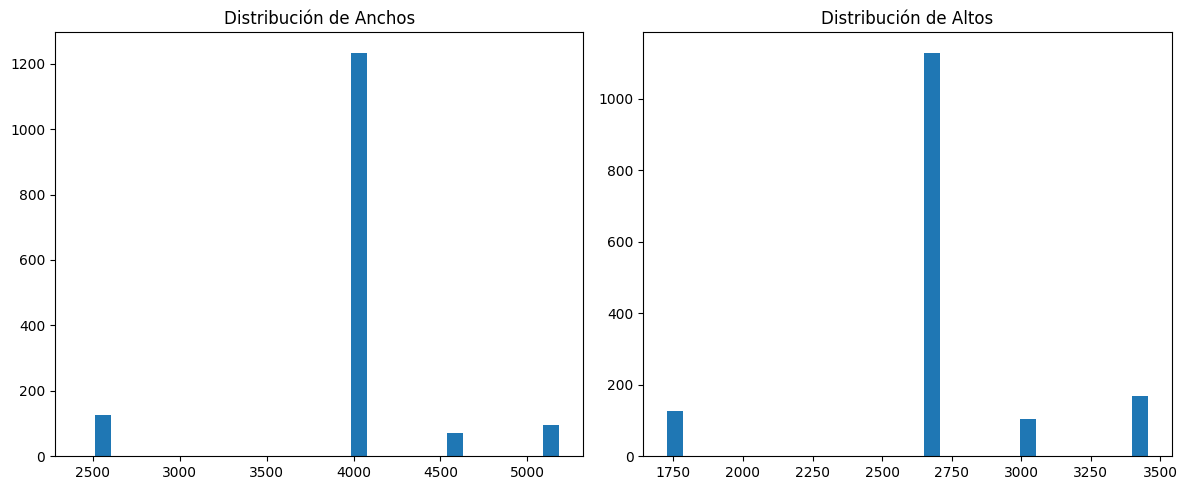

In [29]:
# Distribución de tamaños de imagen (antes de redimensionar)
if image_sizes:
    widths = [s[0] for s in image_sizes]
    heights = [s[1] for s in image_sizes]
    print(f"\n--- Distribución de Tamaños de Imagen Originales ---")
    print(f"Ancho promedio: {np.mean(widths):.2f}, Desviación estándar: {np.std(widths):.2f}")
    print(f"Alto promedio: {np.mean(heights):.2f}, Desviación estándar: {np.std(heights):.2f}")
    print(f"Ancho min: {np.min(widths)}, Ancho max: {np.max(widths)}")
    print(f"Alto min: {np.min(heights)}, Alto max: {np.max(heights)}")

    # Visualizar distribución de tamaños (opcional)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30)
    plt.title('Distribución de Anchos')
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30)
    plt.title('Distribución de Altos')
    plt.tight_layout()
    plt.show()

Hemos notado que, si bien la mayoría de las imágenes en nuestro conjunto de datos comparten tamaños similares, estas dimensiones son considerablemente grandes. Un tamaño de imagen tan grande puede ocasionar problemas de rendimiento durante la ejecución y el entrenamiento del modelo, consumiendo excesivos recursos de memoria y ralentizando el proceso.

Para mitigar estos inconvenientes y optimizar el flujo de trabajo, realizaremos una redimensionamiento de todas las imágenes. Esto nos permitirá mantener la calidad visual necesaria para el análisis, al mismo tiempo que reducimos la carga computacional para un entrenamiento más eficiente.

### **1.4. Relación Entre Variables**
---

Realizaremos un analisis de la composición de color de las imágenes dentro de cada clase. Generando histogramas y calculando estadísticas para los canales Rojo, Verde y Azul (RGB), con esto podremos obtener información valiosa sobre las características visuales que distinguen las plantas Healthy, Powdery y Rust.

In [30]:
target_size = (224, 224) # Ancho, Alto. ¡Recuerda, tamaños grandes causan problemas de memoria!

sample_images_data = [] # Para almacenar arrays de imágenes procesadas
sample_labels_data = [] # Para almacenar las etiquetas de las imágenes procesadas
num_samples_per_class = 5 # Cantidad de imágenes a tomar de cada clase para esta muestra de análisis

print(f"\n--- Procesando una muestra de {num_samples_per_class} imágenes por clase (tamaño objetivo: {target_size}) ---")

for class_name in class_names:
    # Filtra las rutas de imágenes para la clase actual
    class_paths = [p for p, l in zip(all_image_paths, all_labels) if l == class_name]
    np.random.shuffle(class_paths) # Mezcla para tomar muestras aleatorias

    # Tomar un máximo de num_samples_per_class imágenes de la clase actual
    for i in range(min(num_samples_per_class, len(class_paths))):
        img_path = class_paths[i]

        # Abrir, redimensionar, convertir a RGB y normalizar la imagen
        with Image.open(img_path) as img:
            # 1. Redimensionamiento
            img = img.resize(target_size)
            img_array = np.array(img)

            # 2. Asegurarse de que sea RGB (3 canales)
            if img_array.ndim == 2: # Si es escala de grises
                img_array = np.stack([img_array]*3, axis=-1)
            elif img_array.shape[2] == 4: # Si es RGBA (con canal alfa)
                img_array = img_array[..., :3] # Quita el canal alfa

            # 3. Normalización (valores de píxeles de 0-255 a 0-1)
            img_array = img_array / 255.0

            sample_images_data.append(img_array)
            sample_labels_data.append(class_name)

# Convertir la lista de imágenes de muestra a un array NumPy
sample_images_data = np.array(sample_images_data)
print(f"Muestra de imágenes procesadas cargada. Forma del array: {sample_images_data.shape}")

# --- Visualización de Muestras de Imágenes Procesadas (TODAS LAS CLASES) ---
print("\n--- Visualizando una muestra de imágenes procesadas por clase ---")

num_display_images = len(sample_images_data)
cols_plot = 5 # Intentamos 5 columnas por fila para una buena visualización
rows_plot = int(np.ceil(num_display_images / cols_plot))

plt.figure(figsize=(cols_plot * 3, rows_plot * 3)) # Ajusta el tamaño de la figura

for i in range(num_display_images):
    plt.subplot(rows_plot, cols_plot, i + 1)
    plt.imshow(sample_images_data[i])
    plt.title(sample_labels_data[i])
    plt.axis('off') # Oculta los ejes para una vista más limpia
plt.tight_layout() # Ajusta automáticamente los subplots para evitar superposiciones
plt.show()

Output hidden; open in https://colab.research.google.com to view.

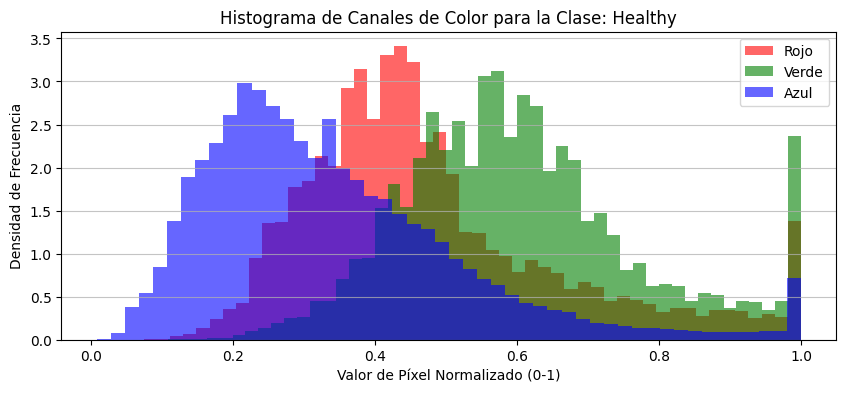

Estadísticas para la Clase: **HEALTHY**
  Media (Rojo): 0.480, Desviación Estándar (Rojo): 0.185
  Media (Verde): 0.604, Desviación Estándar (Verde): 0.167
  Media (Azul): 0.340, Desviación Estándar (Azul): 0.184



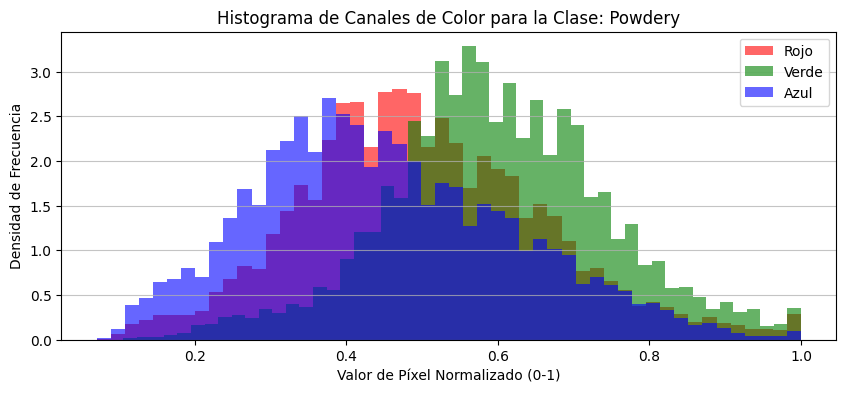

Estadísticas para la Clase: **POWDERY**
  Media (Rojo): 0.501, Desviación Estándar (Rojo): 0.161
  Media (Verde): 0.599, Desviación Estándar (Verde): 0.147
  Media (Azul): 0.452, Desviación Estándar (Azul): 0.171



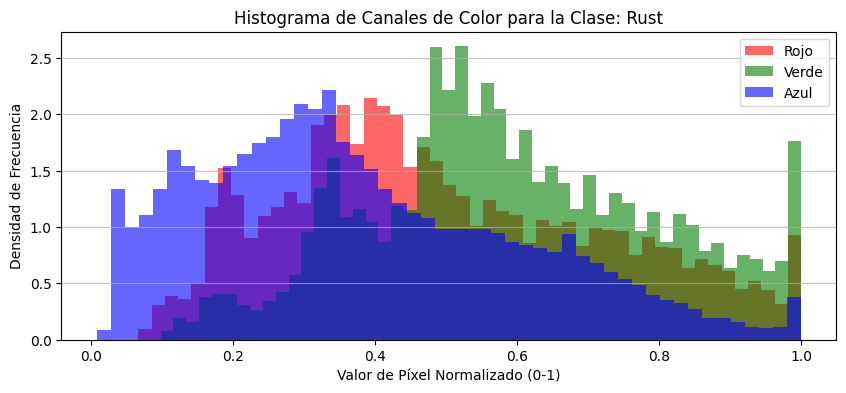

Estadísticas para la Clase: **RUST**
  Media (Rojo): 0.497, Desviación Estándar (Rojo): 0.224
  Media (Verde): 0.590, Desviación Estándar (Verde): 0.204
  Media (Azul): 0.377, Desviación Estándar (Azul): 0.221



In [31]:
for class_name in class_names:
    class_samples = sample_images_data[np.array(sample_labels_data) == class_name]

    # Aplanar los canales de color para el histograma
    red_channel = class_samples[:, :, :, 0].flatten()
    green_channel = class_samples[:, :, :, 1].flatten()
    blue_channel = class_samples[:, :, :, 2].flatten()

    plt.figure(figsize=(10, 4))
    plt.hist(red_channel, bins=50, color='red', alpha=0.6, label='Rojo', density=True)
    plt.hist(green_channel, bins=50, color='green', alpha=0.6, label='Verde', density=True)
    plt.hist(blue_channel, bins=50, color='blue', alpha=0.6, label='Azul', density=True)
    plt.title(f'Histograma de Canales de Color para la Clase: {class_name}')
    plt.xlabel('Valor de Píxel Normalizado (0-1)')
    plt.ylabel('Densidad de Frecuencia')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Estadísticas de media y desviación estándar de los píxeles por canal
    print(f"Estadísticas para la Clase: **{class_name.upper()}**")
    print(f"  Media (Rojo): {np.mean(red_channel):.3f}, Desviación Estándar (Rojo): {np.std(red_channel):.3f}")
    print(f"  Media (Verde): {np.mean(green_channel):.3f}, Desviación Estándar (Verde): {np.std(green_channel):.3f}")
    print(f"  Media (Azul): {np.mean(blue_channel):.3f}, Desviación Estándar (Azul): {np.std(blue_channel):.3f}\n")





*  Healthy (Saludables): Como era de esperar, el verde es el color dominante (media de 0.599), indicando hojas vibrantes. Los canales rojo y azul tienen medias más bajas, lo que es coherente con una planta sana. La baja desviación estándar sugiere tonos de verde muy uniformes.
*  Powdery (Mildiu polvoriento): Aunque el verde sigue siendo predominante (media de 0.588), observamos un aumento en las medias de los canales rojo (0.484) y azul (0.441). Esto sugiere la presencia de tonos más claros o blanquecinos debido al Mildiu polvoriento, que introduce una mezcla de estos colores sobre las hojas. Las desviaciones estándar son ligeramente más altas, indicando una mayor variabilidad tonal por la distribución irregular del polvo.
* Rust (Oxidadas): Aquí, el verde disminuye ligeramente (media de 0.558) y, crucialmente, las desviaciones estándar para todos los canales son las más altas (Rojo: 0.197, Verde: 0.204, Azul: 0.222). Esto indica una gran diversidad de colores y tonos en las imágenes. Es consistente con las manchas rojizas/marrones (altos valores en rojo y quizás verde para el marrón) que contrastan con áreas aún verdes y la variabilidad cromática de una enfermedad de este tipo.

## **2. Limpieza de los Datos**
---
En esta etapa del proceso, vamos a visualizar la estrategia de aumento de datos. Esto nos permitirá ver directamente cómo las transformaciones aplicadas afectan a las imágenes, asegurándonos de que nuestro método de aumento de datos funciona como esperamos antes de aplicarlo a todo el conjunto.

In [32]:
from preprocessing_functions import augment_image_simple
from tensorflow.keras.utils import load_img, img_to_array

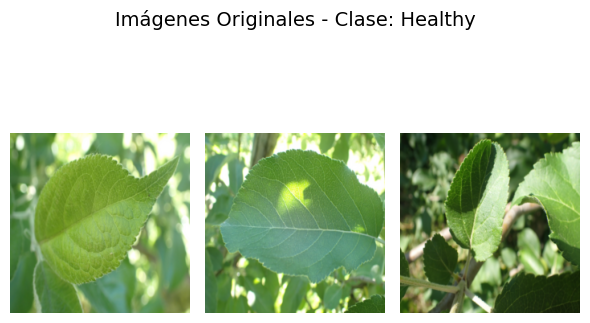

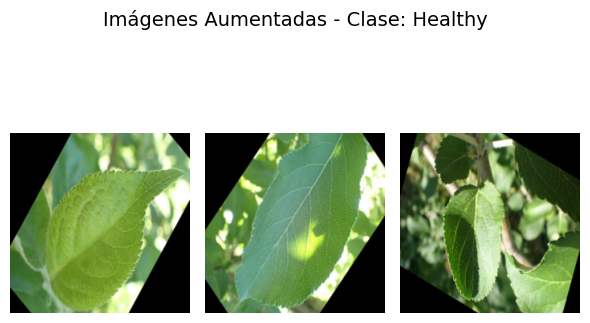

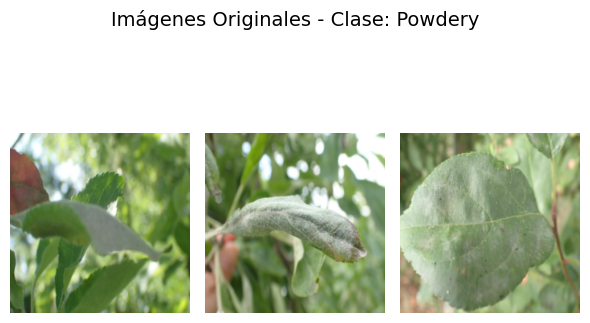

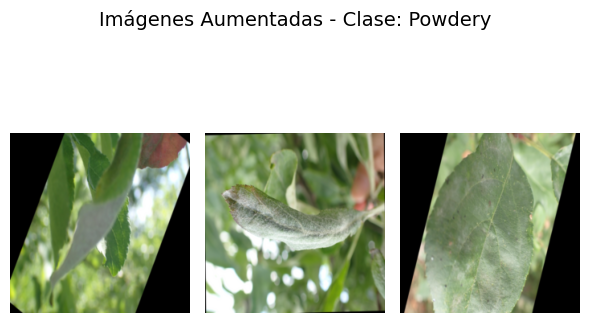

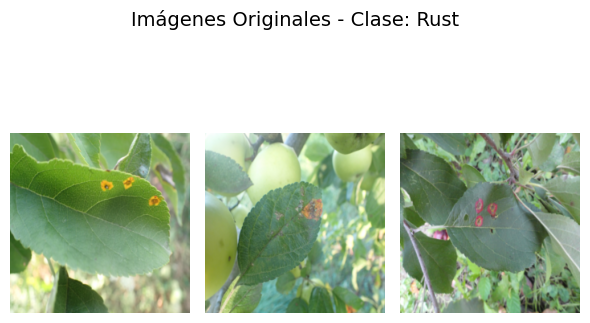

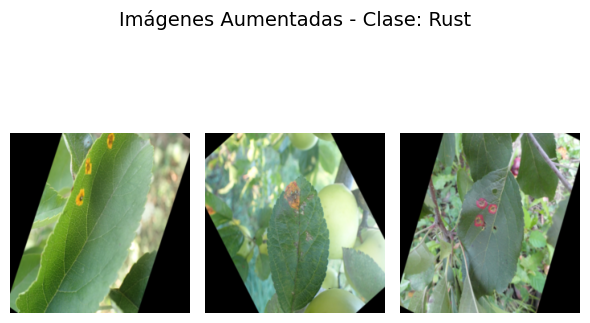

In [33]:
all_image_paths = []
all_labels = []
for class_name in class_names:
    class_dir = os.path.join(df_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            all_image_paths.append(img_path)
            all_labels.append(class_name)

# --- Parámetros de Aumento y Visualización ---
TARGET_SHAPE = [224, 224]
NUM_IMAGES_TO_SHOW_PER_CLASS = 3

sample_images_data = [] # Para almacenar arrays de imágenes procesadas
sample_labels_data = [] # Para almacenar las etiquetas de las imágenes procesadas

for class_name in class_names:

    # Filtra las rutas de imágenes para la clase actual
    class_paths = [p for p, l in zip(all_image_paths, all_labels) if l == class_name]
    np.random.shuffle(class_paths) # Mezcla para tomar muestras aleatorias

    sample_image_paths = class_paths[:NUM_IMAGES_TO_SHOW_PER_CLASS]

    original_images_for_display = []
    augmented_images_for_display = []

    for img_path in sample_image_paths:
        # Cargar la imagen usando Keras, asegurar que sea RGB y normalizar a [0, 1]
        img_pil = load_img(img_path)
        img_array_raw = img_to_array(img_pil)

        if img_array_raw.shape[2] == 4: # Si es RGBA, quitar el canal alfa
            img_array_raw = img_array_raw[:, :, :3]
        elif img_array_raw.ndim == 2: # Si es escala de grises, convertir a RGB
            img_array_raw = np.stack([img_array_raw]*3, axis=-1)

        # Normalizar a [0, 1] y asegurar el tipo float32 para skimage
        image_normalized = img_array_raw.astype(np.float32) / 255.0

        # Redimensionar la imagen original para visualización consistente
        original_resized_img = transform.resize(image_normalized, TARGET_SHAPE, anti_aliasing=True)

        # Aplicar la función de aumento simple
        aug_img = augment_image_simple(image_normalized.copy(), shape=TARGET_SHAPE, flip=True, rotate=[-180, 180])

        original_images_for_display.append(original_resized_img)
        augmented_images_for_display.append(aug_img)

    # --- Visualización de Imágenes Originales ---
    plt.figure(figsize=(2 * NUM_IMAGES_TO_SHOW_PER_CLASS, 4))
    plt.suptitle(f'Imágenes Originales - Clase: {class_name}', fontsize=14)
    for i, disp_img in enumerate(original_images_for_display):
        plt.subplot(1, NUM_IMAGES_TO_SHOW_PER_CLASS, i + 1)
        plt.imshow(disp_img)
        plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Visualización de Imágenes Aumentadas ---
    plt.figure(figsize=(2 * NUM_IMAGES_TO_SHOW_PER_CLASS, 4))
    plt.suptitle(f'Imágenes Aumentadas - Clase: {class_name}', fontsize=14)
    for i, disp_aug_img in enumerate(augmented_images_for_display):
        plt.subplot(1, NUM_IMAGES_TO_SHOW_PER_CLASS, i + 1)
        plt.imshow(disp_aug_img)
        plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


La función de aumento de datos que estamos visualizando ahora es puramente ilustrativa. Su propósito es solo mostrar las transformaciones aplicadas. El método definitivo de aumento de imágenes para el entrenamiento del modelo se especificará y definirá en futuras etapas del proyecto.